# Practice: question answering with retrieval

In this homework you will build a retrieval-based question answering system, one component at a time.

_Okay, realistically, there's like, two components, but technically it's one component at a time._


![img](https://www.cs.upc.edu/~mlatifi/index_files/qa-logo.jpg)



There are two parts to this type of systems: a retriever and a generator.
- the retriever subsystem searches for similar texts from a given databse, e.g. wikipedia
- the generator uses the texts found by the retriever to generate an answer in natural language

_this seminar is based on original notebook by [Oleg Vasilev](https://github.com/Omrigan/)_



In [1]:
!pip install --upgrade accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 6.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found

In [2]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # use 'cuda' for any GPU

### Part 0: the dataset

Before we train anything, let's take a look at the question answering data that we can use. There are several popular datasets, e.g. TriviaQA for trivia questions or GSM8K for math. Today's data is Stanford Question Answering Dataset (SQuAD). Given a paragraph of text and a question, our model's task is to select a snippet that answers the question.

We are not going to solve the full task today. Instead, we'll train a model to __select the sentence containing answer__ among several options.

As usual, you are given an utility module with data reader and some helper functions

In [4]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
%pip install --quiet transformers==4.36.2 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 auto-gptq==0.4.2
# ^-- if this fails, remove the specific version and install latest ones: pip install --update transformers accelerate ...
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2023/week_extra/retrieval/data.py -O data.py
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad-v2.0.json 2> log

import data
# backup download link: https://www.dropbox.com/s/q4fuihaerqr0itj/squad.tar.gz?dl=1
train, test = data.build_dataset('./squad-v2.0.json')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 7.4 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 87.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 92.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
pid, question, options, correct_indices, wrong_indices = train.iloc[40]
print('QUESTION', question, '\n')
print('TEXT SENTENCES')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION Where did Beyonce get her name from? 

TEXT SENTENCES
[ ] Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager.
[v] Beyoncé's name is a tribute to her mother's maiden name.
[ ] Beyoncé's younger sister Solange is also a singer and a former member of Destiny's Child.
[ ] Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry).
[ ] Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard.
[ ] She was raised in a Methodist household.


### Pre-trained BERT
_(but you guessed it)_

We've already solved quite a few tasks from scratch, training our own embeddings and convolutional/recurrent layers. However, one can often achieve higher quality by using pre-trained models. We will default to the good ol' [BERT](https://arxiv.org/abs/1810.04805), though, you are free to use any [other model](https://huggingface.co/models) as you see fit.


In [7]:
from transformers import AutoTokenizer, AutoModel, pipeline

model_name = 'sentence-transformers/bert-base-nli-mean-tokens'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
2025-05-06 23:57:40.729822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746575861.048578      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746575861.118349      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.regis

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [8]:
# just a reminder: here's how it works
dummy_lines = [
    "How old are you?",                                                 # 0
    "In what mythology do two canines watch over the Chinvat Bridge?",  # 1
    "I'm sorry, okay, I'm not perfect, but I'm trying.",                # 2
    "What is your age?",                                                # 3
    "Beware, for I am fearless, and therefore powerful.",               # 4
]

with torch.no_grad():
    batch_tensors = tokenizer(dummy_lines, padding=True, truncation=True, return_tensors="pt")
    out = bert(**batch_tensors)
    token_embs = out.last_hidden_state
    cls_embs = out.pooler_output
    del out


mask = batch_tensors['attention_mask'][..., None].to(torch.float32)
naive_phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


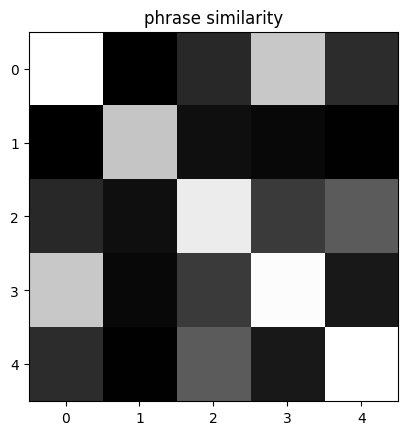

In [9]:
plt.title('phrase similarity')
plt.imshow((naive_phrase_embs @ naive_phrase_embs.t()).cpu().data.numpy(), interpolation='none', cmap='gray')

As you can see, __the strongest similarity is between lines 0 and 3__. Indeed they correspond to "How old are you?" and "What is your age?"

### Retriever Model (2 points)

Our goal for today is to build a model that measures similarity between question and answer. In particular, it maps both question and answer into fixed-size vectors such that:

Our model is a pair of $V_q(q)$ and $V_a(a)$ - networks that turn phrases into vectors.

__Objective:__ Question vector $V_q(q)$ should be __closer__ to correct answer vectors $V_a(a^+)$ than to incorrect ones $V_a(a^-)$ .

Both vectorizers can be anything you wish. For starters, let's use a couple of dense layers on top of the pre-trained encoder.




In [10]:
class Vectorizer(nn.Module):
    def __init__(self, hid_size=256, bert=bert):
        """ A small feedforward network on top of pre-trained encoder. 2-3 layers should be enough """
        super().__init__()
        self.bert = bert
        self.hid_size = hid_size

        # define a few layers to be applied on top of pre-trained BERT
        # note: please make sure your final layer comes with _linear_ activation
        # <YOUR CODE HERE>
        # Freeze BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, hid_size)
        self.relu = nn.ReLU()
        self.to(device)


    def forward(self, input_phrases):
        """
        Apply vectorizer. Use dropout and any other hacks at will.
        :param input_phrases: a list of strings, [batch_size]
        :returns: predicted phrase vectors, [batch_size, output_size]

        Note: you may want to use dropouts.
        if self.training:
          <something>

        Note 2: you may also want to use with torch.no_grad to avoid training BERT for your first attempts

        """

        # In fact, please DO use at least 10% dropout!
        # <YOUR CODE>
        # return <...>
        with torch.no_grad():
            batch = tokenizer(input_phrases, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = self.bert(**batch)

        mask = batch['attention_mask'].unsqueeze(-1).float()
        token_embs = outputs.last_hidden_state
        phrase_embs = (token_embs * mask).sum(1) / mask.sum(1)

        x = self.dropout(phrase_embs)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [16]:
question_vectorizer = Vectorizer()
answer_vectorizer = Vectorizer()

In [17]:
question_vectorizer.train(False)
out1 = question_vectorizer(dummy_lines)
print(out1.shape)
out2 = question_vectorizer(dummy_lines)
assert tuple(out1.shape) == (5, question_vectorizer.hid_size)
assert torch.allclose(out1, out2, atol=1e-5, rtol=0), "Make sure your model disables dropout if training == False"
print("Well done!")

torch.Size([5, 256])
Well done!


### Retriever training: minibatches

Our model learns on triples $(q, a^+, a^-)$:
* q - <b>q</b>uestion
* (a+) - correct <b>a</b>nswer
* (a-) - wrong <b>a</b>nswer

Below you will find a generator that samples such triples from data.

In [18]:
import random

def iterate_minibatches(data, batch_size, shuffle=True, cycle=False):
    """
    Generates minibatches of triples: {questions, correct answers, wrong answers}
    If there are several wrong (or correct) answers, picks one at random.
    """
    indices = np.arange(len(data))
    while True:
        if shuffle:
            indices = np.random.permutation(indices)
        for batch_start in range(0, len(indices), batch_size):
            batch_indices = indices[batch_start: batch_start + batch_size]
            batch = data.iloc[batch_indices]
            questions = batch['question'].values
            correct_answers = np.array([
                row['options'][random.choice(row['correct_indices'])]
                for i, row in batch.iterrows()
            ])
            wrong_answers = np.array([
                row['options'][random.choice(row['wrong_indices'])]
                for i, row in batch.iterrows()
            ])

            yield {
                'questions' : questions,
                'correct_answers': correct_answers,
                'wrong_answers': wrong_answers,
            }
        if not cycle:
            break

In [19]:
dummy_batch = next(iterate_minibatches(train.sample(3), 3))
print(dummy_batch)

{'questions': array(['Why were many killed in Underground Stations?',
       'What is the world of the digimon called?',
       'Al-Andalus was an Emirate of which entity?'], dtype=object), 'correct_answers': array(['Noises of battle were muffled and sleep was easier in the deepest stations, but many were killed from direct hits on several stations.',
       'According to the stories, they are inhabitants of the "DigiWorld", a manifestation of Earth\'s communication network.',
       'Many scholars (including Makdisi) have argued that early medieval universities were influenced by the religious madrasahs in Al-Andalus, the Emirate of Sicily, and the Middle East (during the Crusades).'],
      dtype='<U202'), 'wrong_answers': array(['Although many civilians had used them as such during the First World War, the government in 1939 refused to allow the stations to be used as shelters so as not to interfere with commuter and troop travel, and the fears that occupants might refuse to leave.'

### Retriever training: loss function (2 points)
We want our vectorizers to put correct answers closer to question vectors and incorrect answers farther away from them. One way to express this is to use is Pairwise Hinge Loss _(aka Triplet Loss)_.

$$ L = \frac 1N \underset {q, a^+, a^-} \sum max(0, \space \delta - sim[V_q(q), V_a(a^+)] + sim[V_q(q), V_a(a^-)] )$$

, where
* sim[a, b] is some similarity function: dot product, cosine or negative distance
* δ - loss hyperparameter, e.g. δ=1.0. If sim[a, b] is linear in b, all δ > 0 are equivalent.


This reads as __Correct answers must be closer than the wrong ones by at least δ.__

![img](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/margin.png)
<center>_image: question vector is green, correct answers are blue, incorrect answers are red_</center>


Note: in effect, we train a Deep Semantic Similarity Model [DSSM](https://www.microsoft.com/en-us/research/project/dssm/).

In [20]:
def similarity(a, b):
    """ Dot product as a similarity function """
    # <YOUR CODE>
    # return <...>
    return torch.sum(a * b, dim=1)


def compute_loss(question_vectors, correct_answer_vectors, wrong_answer_vectors, delta=1.0):
    """
    Compute the triplet loss as per formula above.
    Use similarity function above for  sim[a, b]
    :param question_vectors: float32[batch_size, vector_size]
    :param correct_answer_vectors: float32[batch_size, vector_size]
    :param wrong_answer_vectors: float32[batch_size, vector_size]
    :returns: loss for every row in batch, float32[batch_size]
    Hint: you can compute max(0, *) using torch.relu :)
    """
    # <YOUR CODE>
    # return <...>
    pos_sim = similarity(question_vectors, correct_answer_vectors)
    neg_sim = similarity(question_vectors, wrong_answer_vectors)
    print(torch.relu(delta - pos_sim + neg_sim))
    return torch.relu(delta - pos_sim + neg_sim)

In [21]:
dummy_v1 = torch.tensor([[0.1, 0.2, -1], [-1.2, 0.6, 1.0]], dtype=torch.float32)
dummy_v2 = torch.tensor([[0.9, 2.1, -6.6], [0.1, 0.8, -2.2]], dtype=torch.float32)
dummy_v3 = torch.tensor([[-4.1, 0.1, 1.2], [0.3, -1, -2]], dtype=torch.float32)

assert np.allclose(similarity(dummy_v1, dummy_v2).data.numpy(), [7.11, -1.84])
assert np.allclose(compute_loss(dummy_v1, dummy_v2, dummy_v3, delta=5.0).data.numpy(), [0.0, 3.88])

tensor([0.0000, 3.8800])


Once loss is working, let's train our model by our usual means.

In [23]:
def get_recall(questions, correct_answers, wrong_answers):
    """Compute recall using raw text inputs."""
    # Ensure inputs are lists of strings
    questions = [str(q) for q in questions]
    correct_answers = [str(a) for a in correct_answers]
    wrong_answers = [str(a) for a in wrong_answers]

    # Vectorize within get_recall
    v_questions = question_vectorizer(questions)
    v_correct = answer_vectorizer(correct_answers)
    v_incorrect = answer_vectorizer(wrong_answers)

    correct_is_closer = similarity(v_questions, v_correct) > similarity(v_questions, v_incorrect)
    recall = torch.mean(correct_is_closer.to(torch.float32)).item()
    return recall

In [24]:
# make sure it works
get_recall(**dummy_batch)

0.6666666865348816

### Training loop (1 point)

Just as we always do, we can now train DSSM on minibatches and periodically measure recall on validation data.


__Note 1:__ triplet loss training may be very sensitive to the choice of batch size. Small batch size may decrease model quality because there are less negative to consider.

__Note 2:__ here we use the same dataset as __"test set"__ and __"validation (dev) set"__.

In any serious scientific experiment, those must be two separate sets. Validation is for hyperparameter tuning and test is for final eval only.


In [25]:
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm


# Initialize model, optimizers, anything else you want
# <YOUR CODE HERE>

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
question_vectorizer = Vectorizer().to(device)
answer_vectorizer = Vectorizer().to(device)
optimizer = torch.optim.Adam(
    list(question_vectorizer.parameters()) + list(answer_vectorizer.parameters()),
    lr=1e-3
)



ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
dev_batches = iterate_minibatches(test, batch_size=256, cycle=True)
loss_history = []
dev_recall_history = []

/usr/local/lib/python3.11/dist-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


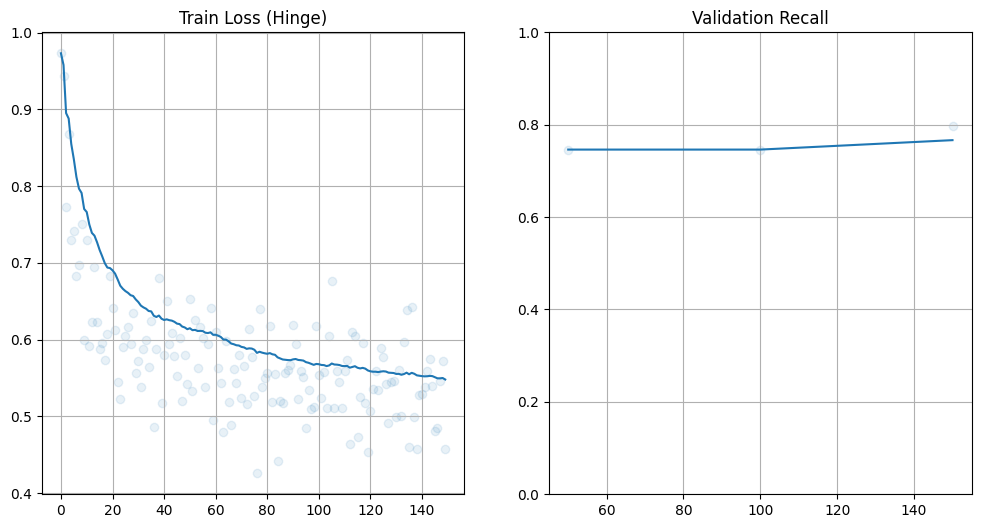

tensor([1.2207, 1.4062, 0.0000, 0.9888, 0.4439, 1.4489, 0.6832, 0.6900, 0.0000,
        1.0042, 0.0000, 0.0000, 0.8859, 0.5267, 0.0000, 1.3539, 0.2838, 1.8072,
        0.5619, 0.0000, 1.3102, 0.0000, 0.0000, 0.8596, 0.0000, 0.0000, 0.6405,
        0.0000, 0.5737, 0.0000, 0.0000, 0.0000, 0.8108, 0.0000, 0.0000, 2.8297,
        4.1464, 0.0000, 0.0000, 0.0000, 1.3861, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 2.8205, 0.2319, 0.0000, 1.0150, 0.0000, 0.0000, 0.5216,
        0.9917, 0.1212, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8580, 0.9680,
        0.0000, 0.0000, 0.0000, 1.4801, 0.0000, 0.0000, 0.0000, 0.8285, 1.5273,
        0.3184, 2.5311, 0.8466, 0.0000, 2.6088, 0.5950, 0.0000, 1.1799, 1.0546,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3508, 0.0000, 0.0000, 0.2092,
        0.0000, 0.6119, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 2.6226, 1.1616, 0.0000, 0.2172, 0.7493, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

KeyboardInterrupt: 

In [ ]:
# infinite training loop. Stop it manually or implement early stopping

# for batch in iterate_minibatches(train, batch_size=256, cycle=True):
for batch_idx, batch in enumerate(iterate_minibatches(train, batch_size=256, cycle=True)):

    # # Perform one training step
    # <YOUR CODE>


    # loss_t = <...>
    # loss_history.append(float(loss_t))

    # Training step
    optimizer.zero_grad()

    # Vectorize batch
    # Convert batch['questions'] to a list of strings
    q_vecs = question_vectorizer(batch['questions'].tolist())
    a_pos_vecs = answer_vectorizer(batch['correct_answers'].tolist())
    a_neg_vecs = answer_vectorizer(batch['wrong_answers'].tolist())

    # Compute loss
    loss = compute_loss(q_vecs, a_pos_vecs, a_neg_vecs)

    # Calculate the mean loss over the batch to get a scalar value
    loss = loss.mean()
    # Backpropagate
    loss.backward()
    optimizer.step()

    # Store loss
    loss_t = loss.item()
    loss_history.append(loss_t)

    # Validation every 50 steps
    if (batch_idx + 1) % 50 == 0:
        
        dev_batch = next(dev_batches)
        with torch.no_grad():
        # Pass raw text to get_recall (no vectorization here)
            recall_t = get_recall(
                dev_batch['questions'].tolist(), 
                dev_batch['correct_answers'].tolist(),
                dev_batch['wrong_answers'].tolist()
            )
        dev_recall_history.append(recall_t)

        # Update plots
        clear_output(True)
        plt.figure(figsize=[12, 6])

        plt.subplot(1, 2, 1)
        plt.title('Train Loss (Hinge)')
        plt.grid()
        plt.scatter(np.arange(len(loss_history)), loss_history, alpha=0.1)
        plt.plot(ewma(loss_history, span=100))

        plt.subplot(1, 2, 2)
        plt.title('Validation Recall')
        plt.grid()
        dev_time = np.arange(1, len(dev_recall_history)+1) * 50
        plt.scatter(dev_time, dev_recall_history, alpha=0.1)
        plt.plot(dev_time, ewma(dev_recall_history, span=10))
        plt.ylim(0, 1)

        plt.show()


In [27]:
print("Mean recall:", np.mean(dev_recall_history[-10:]))
assert np.mean(dev_recall_history[-10:]) > 0.85, "Please train for at least 85% recall on test set. "\
                                                  "You may need to change vectorizer model for that."
print("Well done!")

Mean recall: 0.7630208333333334


AssertionError: Please train for at least 85% recall on test set. You may need to change vectorizer model for that.

# Retriever evaluation (2 point)

Let's see how well does our model perform on actual question answering.

Given a question and a set of possible answers, pick answer with highest similarity to estimate accuracy.

In [28]:
# optional: any additional preparations, e.g. build index
# <...>

def select_best_answer(question, possible_answers):
    """
    Predicts which answer best fits the question
    :param question: a single string containing a question
    :param possible_answers: a list of strings containing possible answers
    :returns: integer - the index of best answer in possible_answer
    """
    # <YOUR CODE>
    # return <...>
    question_vectorizer.eval()
    answer_vectorizer.eval()

    with torch.no_grad():
        # Vectorize question
        q_vec = question_vectorizer([question]).squeeze(0)

        # Vectorize all possible answers
        a_vecs = answer_vectorizer(possible_answers)

        # Compute dot product similarities
        similarities = (a_vecs * q_vec).sum(dim=1)

        # Return index of maximum similarity
        return torch.argmax(similarities).item()


In [29]:
predicted_answers = [
    select_best_answer(question, possible_answers)
    for i, (question, possible_answers) in tqdm(test[['question', 'options']].iterrows(), total=len(test))
]

accuracy = np.mean([
    answer in correct_ix
    for answer, correct_ix in zip(predicted_answers, test['correct_indices'].values)
])
print("Accuracy: %0.5f" % accuracy)
assert accuracy > 0.65, "we need more accuracy!"
print("Great job!")

100%|██████████| 26970/26970 [12:10<00:00, 36.94it/s]

Accuracy: 0.56930


AssertionError: we need more accuracy!

In [31]:
def draw_results(question, possible_answers, predicted_index, correct_indices):
    print("Q:", question, end='\n\n')
    for i, answer in enumerate(possible_answers):
        print("#%i: %s %s" % (i, '[*]' if i == predicted_index else '[ ]', answer))

    print("\nVerdict:", "CORRECT" if predicted_index in correct_indices else "INCORRECT",
          "(ref: %s)" % correct_indices, end='\n' * 3)

In [32]:
for i in [1, 100, 1000, 2000, 3000, 4000, 5000]:
    draw_results(test.iloc[i].question, test.iloc[i].options,
                 predicted_answers[i], test.iloc[i].correct_indices)

Q: Which three countries did Beyonce's song "Work It Out" achieve top ten status?

#0: [*] In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million.
#1: [ ] Beyoncé released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium.
#2: [ ] In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding's character falls in love with.
#3: [ ] The film received mixed reviews from critics but grossed $30 million in the U.S. Beyoncé released "Fighting Temptation" as the lead single from the film's soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film.
#4: [ ] Another of Beyoncé's contributions to the soundtrack, "Summertime", fared better on the US charts.

In [33]:
question = "What is my name?" # your question here!
possible_answers = [
    # <...>
    # # ^- your options.
    "Names are typically given at birth",
    "Your name is specified in your birth certificate",
    "Personal names vary across cultures"
]
predicted_answer = select_best_answer(question, possible_answers)

draw_results(question, possible_answers,
             predicted_answer, [0])

Q: What is my name?

#0: [ ] Names are typically given at birth
#1: [*] Your name is specified in your birth certificate
#2: [ ] Personal names vary across cultures

Verdict: INCORRECT (ref: [0])




### Part 2: to prompt a generator (3 points)

You have built a model that can select the most relevant sentence from a text document. However, this is still not the same as question answering - at least not how humans understand it. The full question answering system shoud answer your question in a dialogue - and perhap even let you ask follow-up questions.

In [ ]:

torch.save({
    'question_state_dict': question_vectorizer.state_dict(),
    'answer_state_dict': answer_vectorizer.state_dict(),
    'hidden_size': question_vectorizer.hid_size,
    'tokenizer': tokenizer  # Save tokenizer if using custom one
}, '/kaggle/working/retriever_model.pth')  # Save in Kaggle working directory


In [ ]:
#For loading retriever
# checkpoint = torch.load(filename, map_location=device)
# model = Vectorizer(hid_size=checkpoint['hidden_size']).to(device)
# model.question_vectorizer.load_state_dict(checkpoint['question_state_dict'])
# model.answer_vectorizer.load_state_dict(checkpoint['answer_state_dict'])    
# optimizer = torch.optim.AdamW(model.parameters())
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])    

In [ ]:

!pip install -U transformers==4.35.0 auto-gptq==0.7.1 optimum==1.16.0

from auto_gptq import AutoGPTQForCausalLM
from transformers import AutoTokenizer

model_name = 'TheBloke/Mistral-7B-Instruct-v0.2-GPTQ'
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load with AutoGPTQ's optimized loader
model = AutoGPTQForCausalLM.from_quantized(
    model_name,
    use_safetensors=True,
    trust_remote_code=True,
    device_map="auto",
    inject_fused_attention=False  # Disable problematic fused attention
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 2.7 MB/s eta 0:00:0000:01
  Using cached accelerate-1.6.0-py3-none-any.whl.metadata (19 kB)
INFO: pip is looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of peft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of datasets to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still 

/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:410: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:418: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/usr/local/lib/python3.11/dist-packages/auto_gptq/nn_modules/triton_utils/kernels.py:461: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

WARNING - Exllamav2 kernel is not installed, reset disable_exllamav2 to True. This may because you installed auto_gptq using a pre-build wheel on Windows, in which exllama_kernels are not compiled. To use exllama_kernels to further speedup inference, you can re-install auto_gptq from source.
WARNING - CUDA kernels for auto_gptq are not installed, this will result in very slow inference speed. This may because:
1. You disabled CUDA extensions compilation by setting BUILD_CUDA_EXT=0 when install auto_gptq from source.
2. You are using pytorch without CUDA support.
3. CUDA and nvcc are not installed in your device.


quantize_config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

INFO - The layer lm_head is not quantized.


  0%|          | 0/1187 [00:00<?, ?w/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [36]:
pid, question, options, correct_indices, wrong_indices = train.iloc[10]
print('QUESTION', question, '\n')
print('TEXT SENTENCES')
for i, cand in enumerate(options):
    print(['[ ]', '[v]'][i in correct_indices], cand)

QUESTION What was the first album Beyoncé released as a solo artist? 

TEXT SENTENCES
[ ] Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress.
[ ] Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.
[ ] Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time.
[v] Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".


In [ ]:

def generate_answer_with_context(question, context_sentences):
    """Generate answer using LLM with retrieved context"""
    # Format context
    context_str = "\n".join([
        f"{i+1}. {sentence}"
        for i, sentence in enumerate(context_sentences)
    ])

    # Create prompt using chat template
    messages = [
        {"role": "user", "content": "Answer questions using ONLY the provided context. Keep answers concise."},
        {"role": "assistant", "content": "Understood! Please provide the question and context."},
        {"role": "user", "content": f"Question: {question}\nContext:\n{context_str}"}
    ]

    # Tokenize and generate
    input_ids = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt"
    ).to(device)

    outputs = model.generate(
        inputs=input_ids,  # Changed to keyword argument
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0][input_ids.shape[1]:], skip_special_tokens=True)
    
# Example usage with data from dataset
pid, question, options, correct_indices, wrong_indices = train.iloc[10]

# Get relevant context using our retriever
context_sentences = [options[i] for i in correct_indices]

# Generate final answer
answer = generate_answer_with_context(question, context_sentences)
print("Question:", question)
print("Generated Answer:", answer)

Question: What was the first album Beyoncé released as a solo artist?
Generated Answer: The first album Beyoncé released as a solo artist was "Dangerously in Love" in 2003.


### Optional tasks for bonus points

There are many ways to improve our question answering model. Here's a bunch of things you can do to increase your understanding and get bonus points.

### 1.  Hard Negatives (2+ pts)

Not all wrong answers are equally wrong. As the training progresses, _most negative examples $a^-$ will be to easy._ So easy in fact, that loss function and gradients on such negatives is exactly __0.0__. To improve training efficiency, one can __mine hard negative samples__.

Given a list of answers,
* __Hard negative__ is the wrong answer with highest similarity with question,

$$a^-_{hard} = \underset {a^-} {argmax} \space sim[V_q(q), V_a(a^-)]$$

* __Semi-hard negative__ is the one with highest similarity _among wrong answers that are farther than positive one. This option is more useful if some wrong answers may actually be mislabelled correct answers.

* One can also __sample__ negatives proportionally to $$P(a^-_i) \sim e ^ {sim[V_q(q), V_a(a^-_i)]}$$


The task is to implement at least __hard negative__ sampling and apply it for model training.


### 2. Better prompting (2+ pts)

In the previous example, we manually engineer a prompt for an LLM to solve produce an answer. However, by this point you know multiple ways to make LLM do your bidding. In this assignment, you should try at least some of them:
- try few-shot learning with several handcrafted examples (or hand-picked model inputs)
- compare several instruct and/or non-instruct models; for non-instruct models
  - please not that you should not use apply_chat_template for non-instruct models
- provide some means of quality evaluation to compare your approach against the default one

At the minimum, several (10-20) side-by-side examples would do the trick. However, we'd appreciate creative means of evaluation here (crowdsourcing, asking another LM, anything exotic as long as you can explain it).

### 3. Search engine (3+ pts)

Our basic model only selects answers from 2-5 available sentences in paragraph. You can extend it to search over __the whole dataset__. All sentences in all other paragraphs are viable answers.

The goal is to train such a model and use it to __quickly find top-10 answers from the whole set__.

* You can ask such model a question of your own making - to see which answers it can find among the entire training dataset or even the entire wikipedia.
* Searching for top-K neighbors is easier if you use specialized methods: [KD-Tree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) or [HNSW](https://github.com/nmslib/hnswlib).
* This task is much easier to train if you use hard or semi-hard negatives. You can even find hard negatives for one question from correct answers to other questions in batch - do so in-graph for maximum efficiency. See [1.] for more details.
